In [4]:


import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *



processGens=ProcessGens()


process_gen_modes=["mistral_wmt"]
do_norm_analysis=True
processGens.init_with_mode(process_gen_modes)
root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric = processGens.get_params()

examples_df, completions_df=get_dfs(processGens)


dfs_by_model={}

for model_name in examples_df['model'].unique():
    filtered_df = examples_df[examples_df["model"]==model_name]
    filtered_df["rank"]=100-filtered_df["example_idx"]
    dfs_by_model[model_name]=filtered_df

all_dfs_by_model=dfs_by_model


Init: process_gens_mode ['mistral_wmt']
mode is wmttask_names is ['wmt_14_language_pair_de_en_']
calculate_gen_summary_dict
snellius_copies/helm_output/sample_100_eval_500_first_inst_0/wmt_14_language_pair_de_en_/mistralai_Mistral_7B_Instruct_v0.3/1_beams/runs/sample_100_eval_500_first_inst_0
get_metrics_dict
Index(['example_comet', 'beam_num', 'task_name', 'model', 'example_idx',
       'rank', 'suite', 'instanceID', 'text', 'completion_length',
       'output_logprob', 'isCompletion'],
      dtype='object')
Num examples: 50000
Num completions: 500


In [5]:
print(f"\t root_folder: {root_folder} \n \t num_beams_list {num_beams_list} \n \t models: {models} \n \t custom_metrics{[metric.name() for metric in custom_metrics]}"+ 
    f"\n \t task_names {task_names} \n \t suite_name {suite_name} \n \t instance_metrics {instance_metrics}")
# instanceGeneration=get_first(processGens.first_run_instances)
print(examples_df.head(2))
print("num examples" ,len(examples_df))
print("num_completions", len(completions_df))
print(f"compare_metric mean: ",examples_df[[compare_metric]].mean())
#current belief: for each run_folder combo, there will be 100 instances and 100 examples per instance

max_example_idx = examples_df["example_idx"].max()
plots_wide=1
num_models=len(dfs_by_model.keys())
plots_tall=math.ceil(num_models/plots_wide)

df=next(iter(dfs_by_model.values()))

	 root_folder: snellius_copies/helm_output 
 	 num_beams_list [1] 
 	 models: ['mistralai/Mistral-7B-Instruct-v0.3'] 
 	 custom_metrics[]
 	 task_names ['wmt_14_language_pair_de_en_'] 
 	 suite_name sample_100_eval_500_first_inst_0 
 	 instance_metrics ['comet']
   example_comet  beam_num                    task_name  \
0       0.267811         1  wmt_14_language_pair_de_en_   
1       0.267811         1  wmt_14_language_pair_de_en_   

                                model  example_idx  rank  \
0  mistralai/Mistral-7B-Instruct-v0.3            0   100   
1  mistralai/Mistral-7B-Instruct-v0.3            1    99   

                              suite  instanceID text  completion_length  \
0  sample_100_eval_500_first_inst_0           0                       0   
1  sample_100_eval_500_first_inst_0           0                       0   

   output_logprob isCompletion  
0       -2.913491         True  
1       -2.913491         None  
num examples 50000
num_completions 500
compare_metric

Text(0, 0.5, 'example_comet')

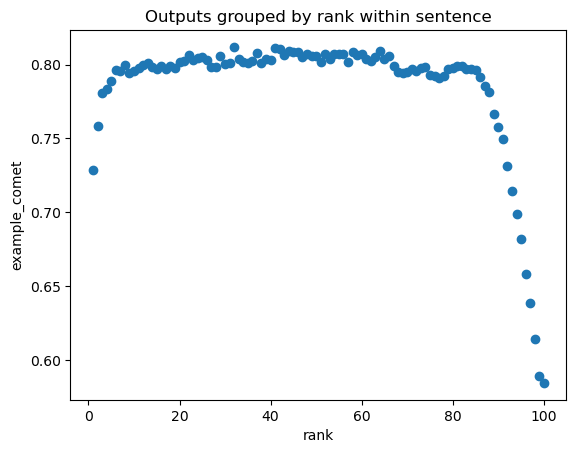

In [7]:
def plot_grouped(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=True):
    if(ax is None):
        _, ax = plt.subplots()
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if(groupby=="bins"):
        df["bins"]=pd.qcut(df[xlabel],nbins)
    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])
    
    x = grouped[(xlabel, 'mean')]
    y = grouped[(ylabel, 'mean')]
    yerr = grouped[(ylabel, 'std')]

    yerr=[]
    for i in grouped.index:
        # print(grouped.loc[i][ylabel])
        _, c, s = grouped.loc[i][ylabel]
        if c>0:
            yerr.append(1.96*s/math.sqrt(c))

    # Plot with error bars (standard deviation)
    if error_bar:
        ax.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=3, label='Data with std dev')
    else:
        ax.scatter(x,y)

    # plt.scatter(x,y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if(title):
        ax.set_title(title)

    if(trend_line=="None"):
        pass
    elif(trend_line=="linear"):
        try:
            ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
        except:
            pass
    else: 
        raise Exception("Plot_keys errors: did not recognize trend_line type")
        
    return ax, grouped


# df = df.head(10)
compare_metric="example_comet"
fig, ax = plt.subplots()
suptitle=f"Outputs grouped by rank within sentence"

# top_df = df[df['example_idx']<85]
xlabel="rank"
ax, grouped =plot_grouped(df=df, xlabel=xlabel,groupby='example_idx', ylabel=compare_metric, title=suptitle, ax=ax, error_bar=False)
ax.set_xlabel(xlabel)
ax.set_ylabel(compare_metric)

